# Notebook Description

Correlation between RMM and AWAP rainfall indices in MJO subphases.

# Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from constants import NWABounds
import constants
import calculation_functions
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr

import matplotlib.gridspec as gridspec

In [2]:
import sys
from importlib import reload
sys.path.append('')
import load_dataset as load
import phase_calc_functions as phase_calc
import map_trend_functions
import phase_plot_functions as phase_plot
import miscellaneous#apply_masks

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pylab as pylab

params = {'axes.labelsize' : 16,
         'legend.fontsize': 'x-large',
          'axes.titlesize': 'xx-large',
         }

pylab.rcParams.update(params)

In [4]:
image_dir = '/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/'

# Data

In [12]:
reload(constants)

<module 'constants' from '/home/563/ab2313/Documents/mjo_and_rainfall_trend/constants.py'>

In [13]:
# Loading awap
awap = load.load_awap()
awap_ws = phase_calc.wet_season_year(awap)

In [14]:
# Loading RMM
rmm = load.load_rmm()
rmm_ws = phase_calc.wet_season_year(rmm)

In [15]:
awap_ws, rmm_ws = calculation_functions.match_dataset_time(awap_ws, rmm_ws )

New datasets are now of lenght d1 = 5578 and d2 = 5578


In [16]:
awap_ws = miscellaneous.apply_masks(awap_ws)

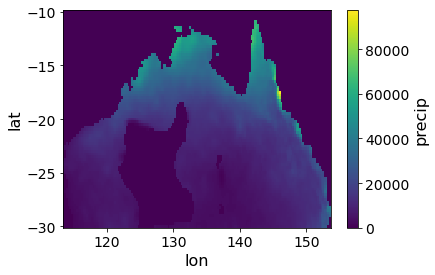

In [17]:
awap_ws.sum(dim = 'time').precip.plot()

# Phase Splitting and Wet Season Calibration

Splitting into different MJO phases (1-8) and then moving the data from Jan-March back one year. The moving of the data back one year means that all of the data for an individual wet season is now with in the one year. This makes resampling much easier.

In [18]:
# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [19]:
np.unique(awap_ws.time.dt.year.values)

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [20]:
np.unique(rmm_ws.time.dt.year.values)

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [21]:
len(np.unique(awap_ws.time.dt.year.values))

46

In [22]:
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)
rmm_count = calculation_functions.convert_time_to_year(rmm_count)
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)
rmm_count_sub

<xarray.Dataset>
Dimensions:  (phase: 4, year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 21 28 25 18 23 28 11 ... 43 29 18 56 15 23 46

# RMM Enahnced with Total Monsoon Rainfall

In [50]:
def trend_line(y, use = [0][0]):
    '''
    Parameters
    ----------
    x: the y values of our trend
    use: 
    [0][0] will just return the gradient
    [0,1] will return the gradient and y-intercept.
    Previosly: _grid_trend
    '''
#     if ~isinstance(y, np.ndarray) or ~isinstance(y, list):
#         return np.nan

    if all(~np.isfinite(y)):
        return np.nan


    # Getting the gradient of a linear interpolation
    x = np.arange(len(y))
    idx = np.isfinite(y) #checking where the nans.
    x = x[idx]
    y = y[idx]

    if len(x) < 3:
        return np.nan

    poly = np.polyfit(x,y,1)

    return poly[use].round(2)

In [137]:
def create_trend_line(y_values, x_values=None): 
    
    if x_values is None:
        x_values = np.arange(len(y_values))
    grad, y_int = np.polyfit(x_values,y_values,1)
#     print(grad, y_int)
    
    
    y_line = grad * x_values + y_int
    
    return y_line

In [138]:
rmm_count_enhanced_trend = create_trend_line(rmm_count_sub.sel(phase='enhanced').number.values,
                                    rmm_count_sub.year.values
                                        )
rmm_count_sub_enhanced_detrend = rmm_count_sub.sel(phase='enhanced') - rmm_count_enhanced_trend

In [162]:
rmm_sub_trend = np.apply_along_axis(
    create_trend_line, rmm_count_sub.number.get_axis_num('year'), rmm_count_sub.number.values, 
    rmm_count_sub.year.values)

rmm_sub_trend_ds = xr.zeros_like(rmm_count_sub) + rmm_sub_trend
rmm_sub_detrend_ds = rmm_count_sub - rmm_sub_trend_ds
rmm_sub_detrend_ds

<xarray.Dataset>
Dimensions:  (year: 46, phase: 4)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) float64 2.161 8.667 5.173 ... -20.34 -12.1 11.13

## Global

In [24]:
awap_sum = calculation_functions.resample_sum(awap_ws)
awap_count = calculation_functions.resample_count(awap_ws)
awap_count

<xarray.Dataset>
Dimensions:  (year: 46, lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
Data variables:
    precip   (year, lat, lon) int64 0 0 0 0 0 0 5 6 5 8 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

In [136]:
time_axis_num = awap_sum.precip.get_axis_num('year')
time_axis_num

0

In [147]:
awap_sum_trend = np.apply_along_axis(create_trend_line, time_axis_num, awap_sum.precip.values, 
                                     awap_sum.year.values)

awap_sum_trend_ds = xr.zeros_like(awap_sum) + awap_sum_trend

awap_sum_detrend_ds = awap_sum - awap_sum_trend_ds
awap_sum_detrend_ds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
Data variables:
    precip   (year, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [151]:
time_axis_num = awap_count.precip.get_axis_num('year')

awap_count_trend = np.apply_along_axis(create_trend_line, time_axis_num, awap_count.precip.values, 
                                     awap_count.year.values)

awap_count_trend_ds = xr.zeros_like(awap_count) + awap_count_trend

awap_count_detrend_ds = awap_count - awap_count_trend_ds
awap_count_detrend_ds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
Data variables:
    precip   (year, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [163]:
awap_count_rmm_cor = xr.corr(awap_count_detrend_ds.precip, rmm_sub_detrend_ds.number, dim='year')
awap_sum_rmm_cor = xr.corr(awap_sum_detrend_ds.precip, rmm_sub_detrend_ds.number, dim='year')
awap_count_rmm_cor

<xarray.DataArray (lat: 80, lon: 161, phase: 4)>
array([[[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        ...,
        [-0.04057321,  0.24443867,  0.03045372, -0.18344024],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]],

       [[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        ...,
        [-0.05263452,  0.25625631,  0.06207272, -0.19316017],
        [ 0.01004001,  0.23609719,  0.04149762, -0.20111216],
        [        nan,         nan,         nan,         nan]],

       [[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        ...,
...
        ...,
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]],

       [[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        ...,
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]],

       [[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        ...,
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]]])
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [164]:
np.max([awap_sum_rmm_cor.max().values,awap_count_rmm_cor.max().values])

0.5109327586030906

[-5.00000000e-01 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01
 -1.00000000e-01 -1.11022302e-16  1.00000000e-01  2.00000000e-01
  3.00000000e-01  4.00000000e-01  5.00000000e-01]
Saving to /g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/04_total_wet_season_rainfall_correlation_with_number_days_in_rmm_phase.png


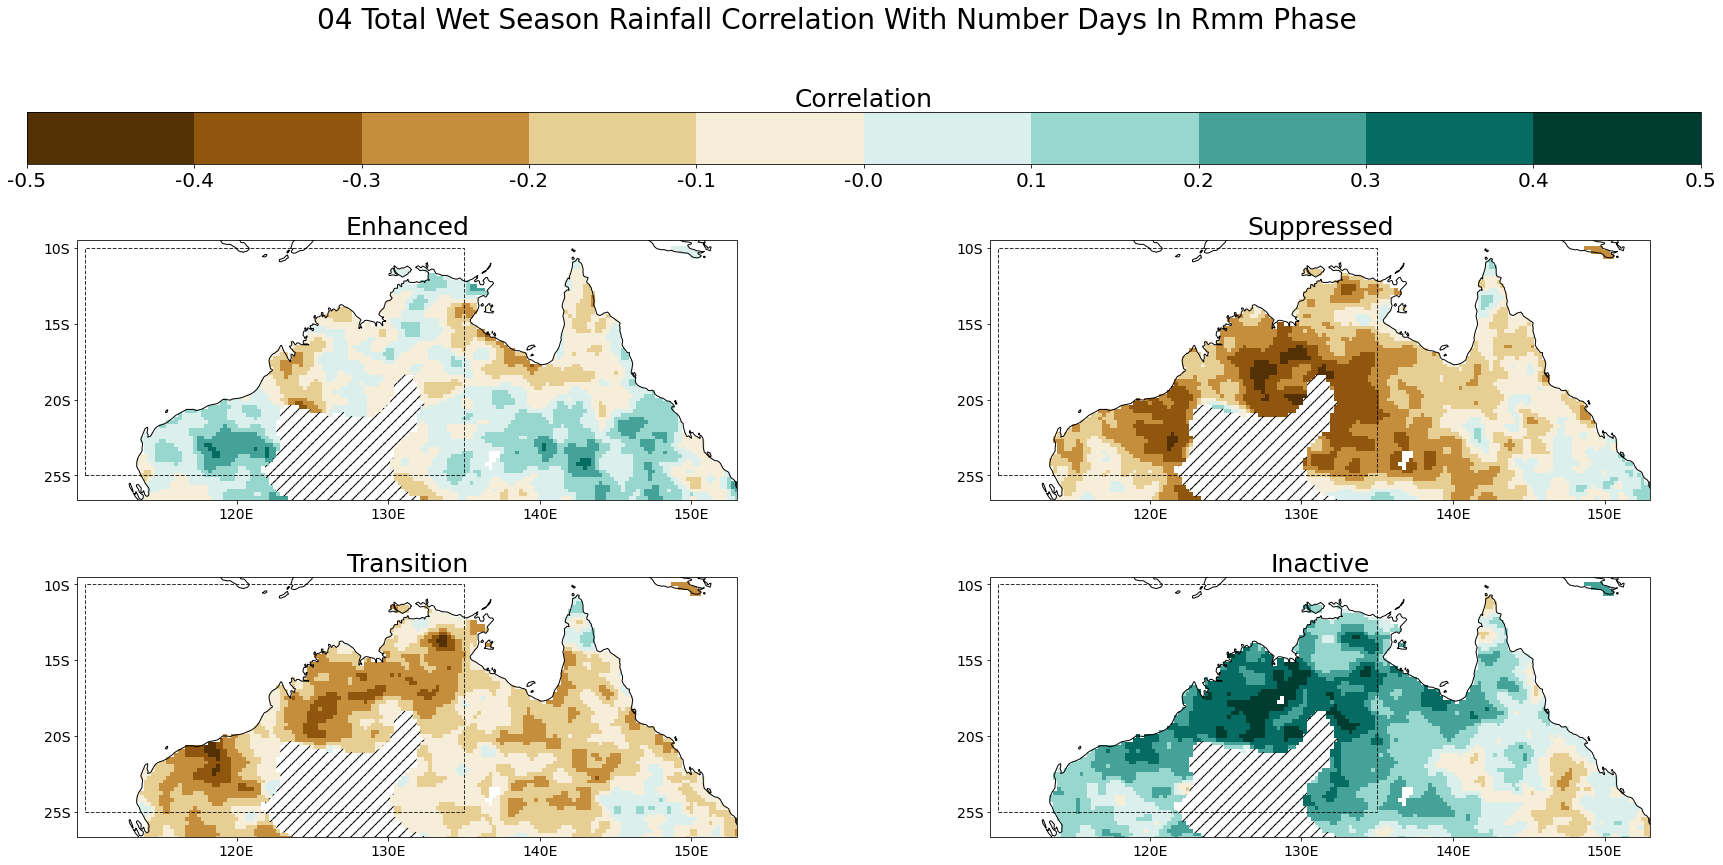

In [168]:
reload(map_trend_functions)
map_trend_functions.trend_plots(awap_sum_rmm_cor,
               vmax = 0.5, step = 0.1, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_total_wet_season_rainfall_correlation_with_number_days_in_rmm_phase', 
                                colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

[-5.00000000e-01 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01
 -1.00000000e-01 -1.11022302e-16  1.00000000e-01  2.00000000e-01
  3.00000000e-01  4.00000000e-01  5.00000000e-01]
Saving to /g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/04_total_wet_season_number_rain_days_correlation_with_number_days_in_rmm_phase.png


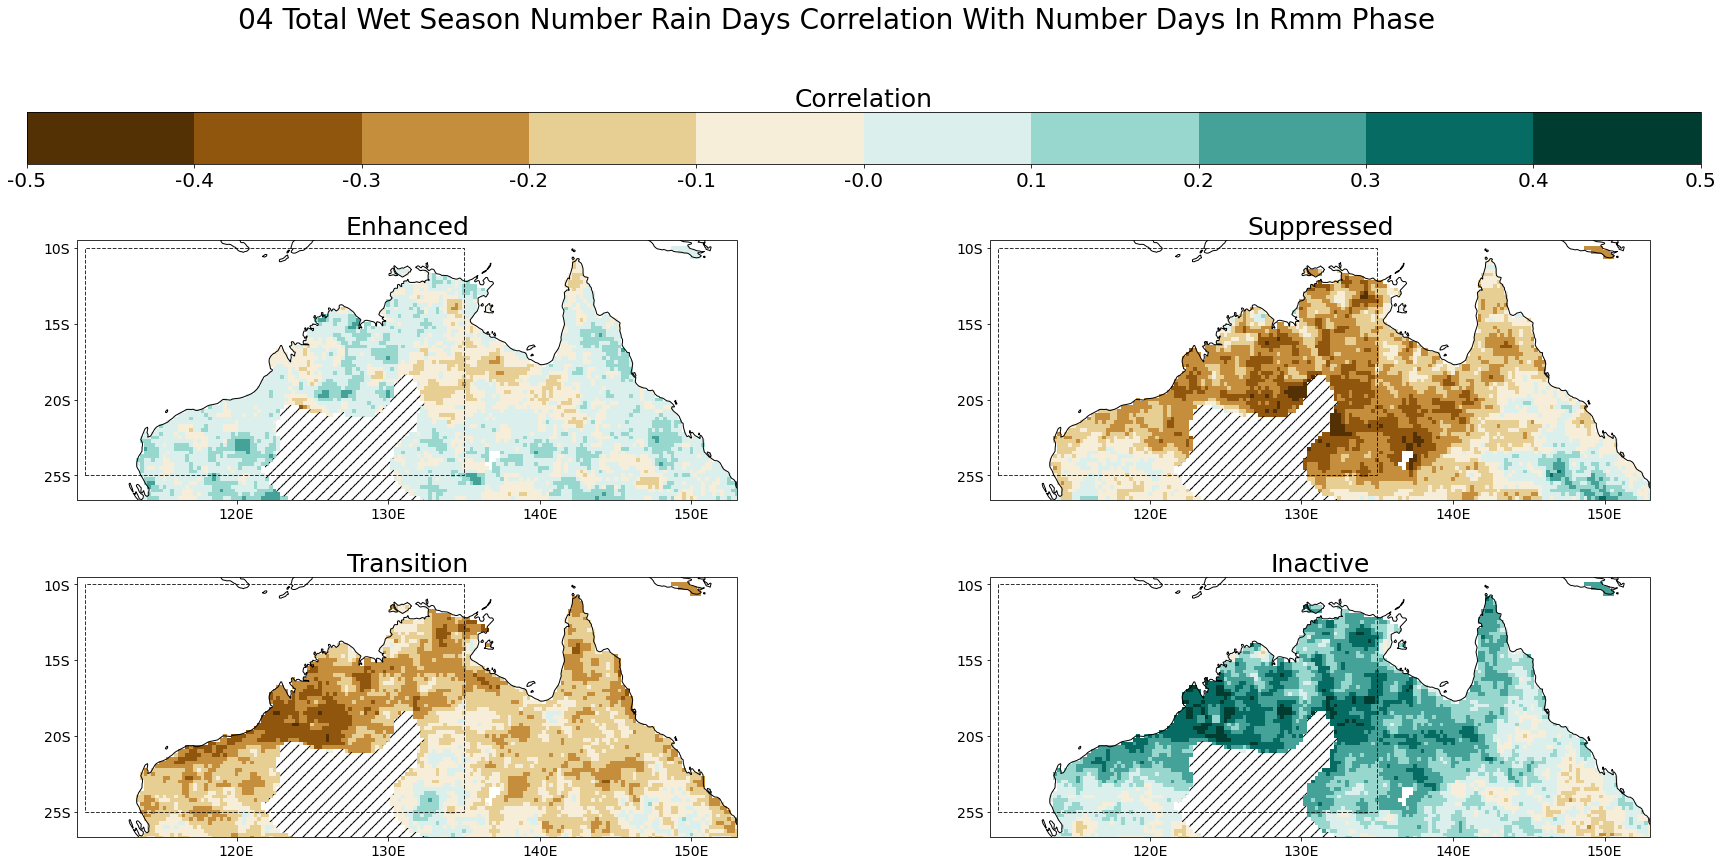

In [167]:
reload(map_trend_functions)
map_trend_functions.trend_plots(awap_count_rmm_cor,
               vmax = 0.5, step = 0.1, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_total_wet_season_number_rain_days_correlation_with_number_days_in_rmm_phase', colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

In [29]:
awap_sum_agg = awap_count.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).mean(dim=['lat', 'lon'])
awap_sum_agg

<xarray.Dataset>
Dimensions:  (year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
Data variables:
    precip   (year) float64 15.88 20.44 17.17 19.22 ... 23.37 17.66 12.13 13.58

## Global

In [139]:
awap_sum_agg_trend = create_trend_line(awap_sum_agg.precip.values, awap_sum_agg.year.values)

In [101]:
awap_sum_agg_detrend = awap_sum_agg - awap_sum_agg_trend


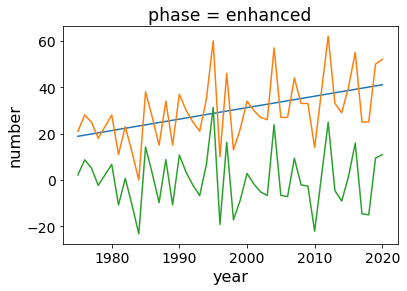

In [108]:
plt.plot(rmm_count_sub.year.values, rmm_count_trend)
rmm_count_sub.sel(phase='enhanced').number.plot()
rmm_count_sub_enhanced_detrend.number.plot()

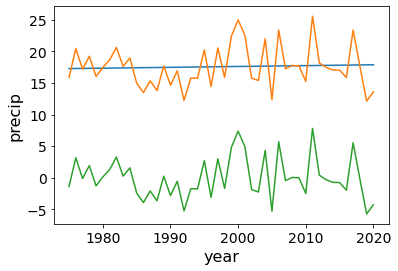

In [109]:
plt.plot(awap_sum_agg.year.values, awap_sum_agg_trend)
awap_sum_agg.precip.plot()
awap_sum_agg_detrend.precip.plot()

In [121]:
from scipy.stats import pearsonr

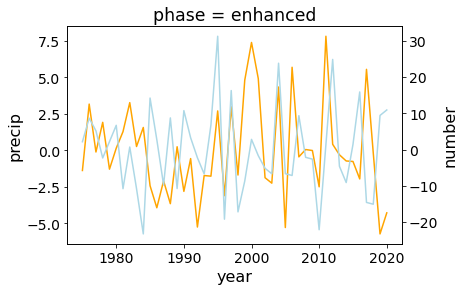

In [128]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
awap_sum_agg_detrend.precip.plot(ax=ax1, c='orange')
ax2 = ax1.twinx()
rmm_count_sub_enhanced_detrend.number.plot(ax=ax2, c='lightblue')

In [130]:
pearsonr(awap_sum_agg_detrend.precip.values, rmm_count_sub_enhanced_detrend.number.values)[0]

0.039560269227839326

In [30]:
rmm_count_sub.sel(phase='enhanced')

<xarray.Dataset>
Dimensions:  (year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
    phase    <U8 'enhanced'
Data variables:
    number   (year) int64 21 28 25 18 23 28 11 23 12 ... 33 29 40 55 25 25 50 52

In [31]:
from scipy.stats import spearmanr

correlation_sum_agg = spearmanr(awap_sum_agg.precip.values, rmm_count_sub.sel(phase='enhanced').number.values)
correlation_sum_agg

SpearmanrResult(correlation=0.033334377430550934, pvalue=0.8259304933398107)

Text(0, 0.5, 'Mean Total Monsoon Rain Days')

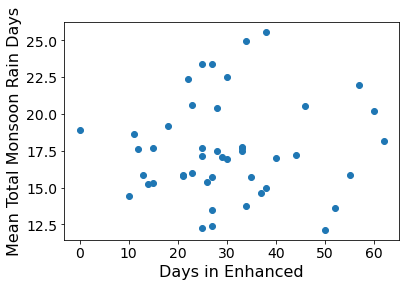

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(rmm_count_sub.sel(phase='enhanced').number.values, awap_sum_agg.precip.values)
ax.set_xlabel('Days in Enhanced')
ax.set_ylabel('Mean Total Monsoon Rain Days')

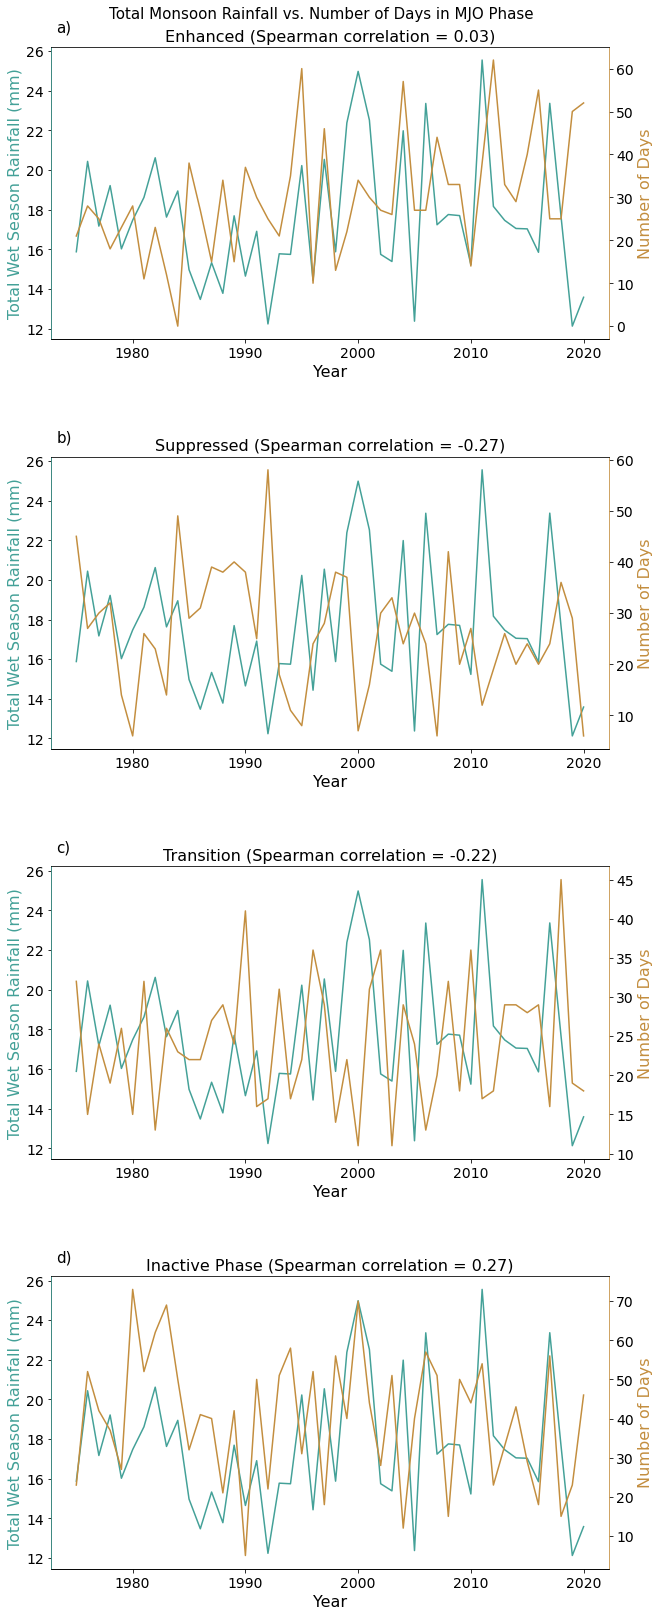

In [33]:
fig = plt.figure(figsize = (10,28/4*4)) #(18,20))
gs = gridspec.GridSpec(4,1, hspace = 0.4)


sig_stor = []

years = awap_sum_agg.year.values

for i, phase in enumerate(rmm_count_sub.phase.values):
    ax = fig.add_subplot(gs[i])
    
    ax.plot(years, awap_sum_agg.precip.values, color=constants.green, 
            label='Total Wet Season Rainfall (mm)')
    ax2 = ax.twinx()
    ax2.plot(years, rmm_count_sub.sel(phase=phase).number.values, color=constants.brown, 
             label='Days in MJO Phase')


    ax.set_ylabel('Total Wet Season Rainfall (mm)', color=constants.green)
    ax2.set_ylabel('Number of Days', color=constants.brown)                     
    ax.set_xlabel('Year')
    
#     leg = ax.legend(loc = 'upper left', ncol=2)
    scor = spearmanr(awap_sum_agg.precip.values, rmm_count_sub.sel(phase=phase).number.values)
    title = phase.capitalize() if phase != 'inactive' else 'Inactive Phase'
    title = title + f' (Spearman correlation = {scor[0]:.2f})'
    ax.set_title(title, size=16)

#     leg.set_title(f'Correlation - {scor[0]:.2f}')
    
    ax2.spines['left'].set_color(constants.green)
    ax2.spines['right'].set_color(constants.brown)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.annotate(chr(97+i) +')', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


title = 'Total Monsoon Rainfall vs. Number of Days in MJO Phase'
fig.suptitle(title, y =0.9, fontsize = 15 );


# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '04_enhanced_trend_and_phase_sum_rainfall.png'), 
#                          dpi = 800, bbox_inches = 'tight')

In [34]:
scor[0]

0.2721185812126504

# Phase

In [35]:
awap_count_phase = calculation_functions.resample_count(awap_split_ws)
awap_count_sub = phase_calc.resample_phase_to_subphase(awap_count_phase)
awap_count_sub 

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, phase: 4, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) int64 0 0 0 0 0 0 3 4 3 ... 0 0 0 0 0 0 0 0

In [36]:
awap_sum_phase = calculation_functions.resample_sum(awap_split_ws)
awap_sum_sub = phase_calc.resample_phase_to_subphase(awap_sum_phase)
awap_sum_sub 

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, phase: 4, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [37]:
awap_int = awap_sum.sum(dim='year')/awap_count.sum(dim='year')
awap_int

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
Data variables:
    precip   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [38]:
awap_sum_sub

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, phase: 4, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [39]:
sum_corr_da = xr.corr(awap_sum_sub.precip, rmm_count_sub.number, dim='year')
count_corr_da = xr.corr(awap_count_sub.precip, rmm_count_sub.number, dim='year')
sum_corr_da

<xarray.DataArray (phase: 4, lat: 80, lon: 161)>
array([[[       nan,        nan,        nan, ..., 0.64909926,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.63525982,
         0.60436718,        nan],
        [       nan,        nan,        nan, ..., 0.62762011,
         0.60306473,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.64752192,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.65228571,
         0.70228879,        nan],
        [       nan,        nan,        nan, ..., 0.68934609,
         0.72140786,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.52633292,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.5654324 ,
         0.56277389,        nan],
        [       nan,        nan,        nan, ..., 0.56085511,
         0.56387334,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [40]:
np.max([sum_corr_da.max().values, sum_corr_da.max().values])

0.876881301902392

[-9.00000000e-01 -7.50000000e-01 -6.00000000e-01 -4.50000000e-01
 -3.00000000e-01 -1.50000000e-01  1.11022302e-16  1.50000000e-01
  3.00000000e-01  4.50000000e-01  6.00000000e-01  7.50000000e-01
  9.00000000e-01  1.05000000e+00]
Saving to /g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/04_phase_rainfall_correlation_with_number_days_in_rmm_phase.png


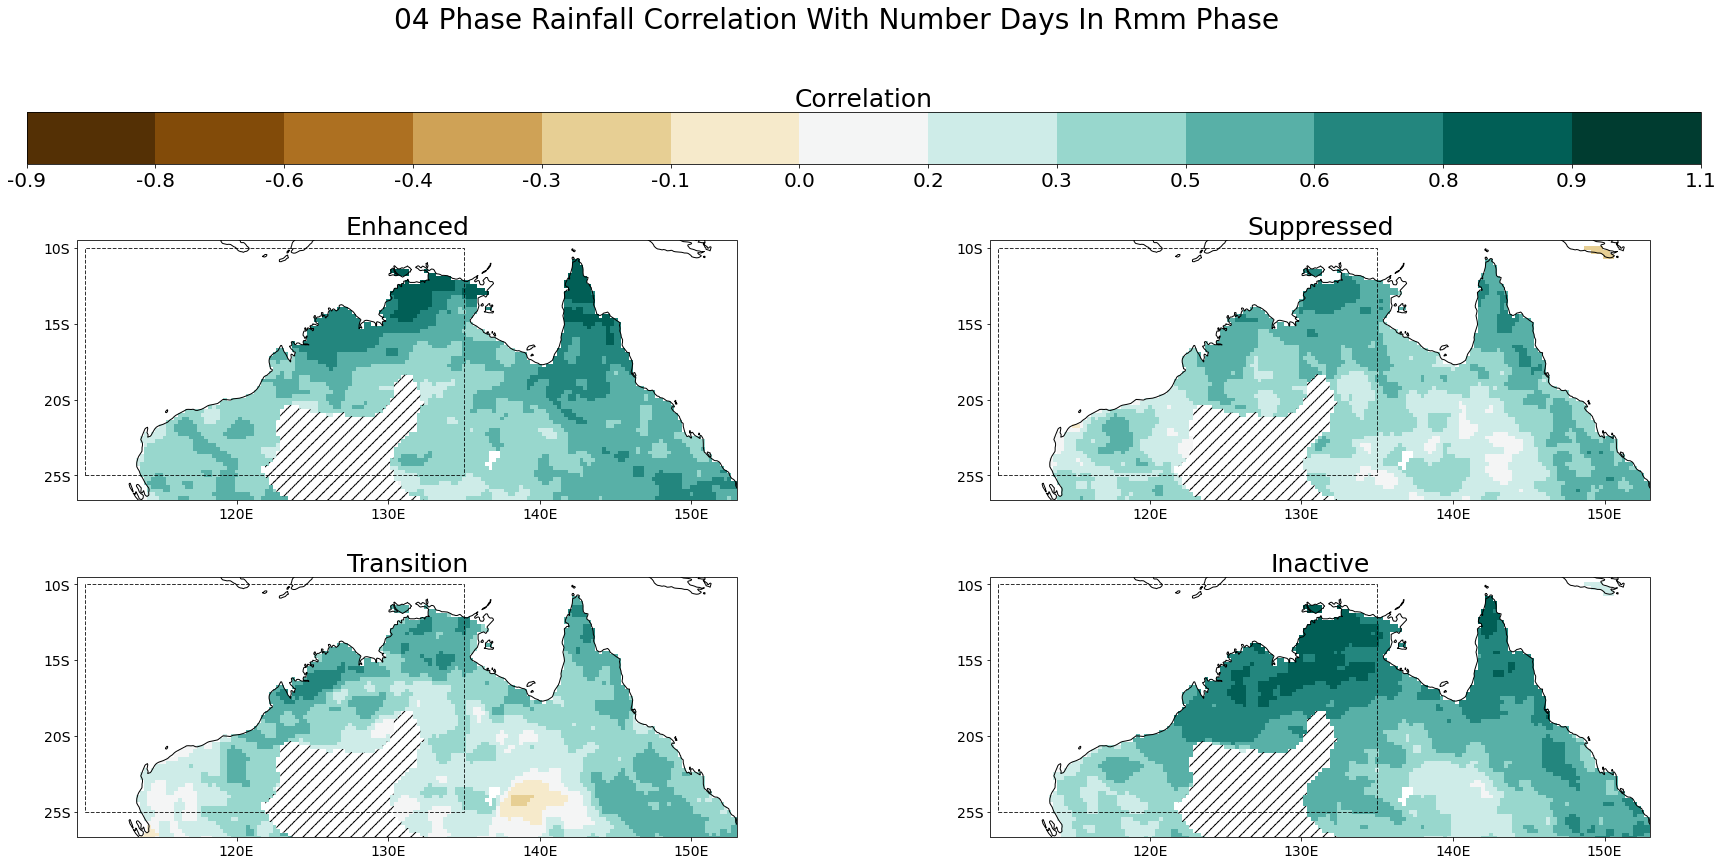

In [41]:
reload(map_trend_functions)
map_trend_functions.trend_plots(sum_corr_da,
               vmax = 0.9, step = 0.15, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_phase_rainfall_correlation_with_number_days_in_rmm_phase', colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

[-1.00000000e+00 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.22044605e-16  2.00000000e-01  4.00000000e-01
  6.00000000e-01  8.00000000e-01  1.00000000e+00]
Saving to /g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/04_phase_rain_days_correlation_with_number_days_in_rmm_phase.png


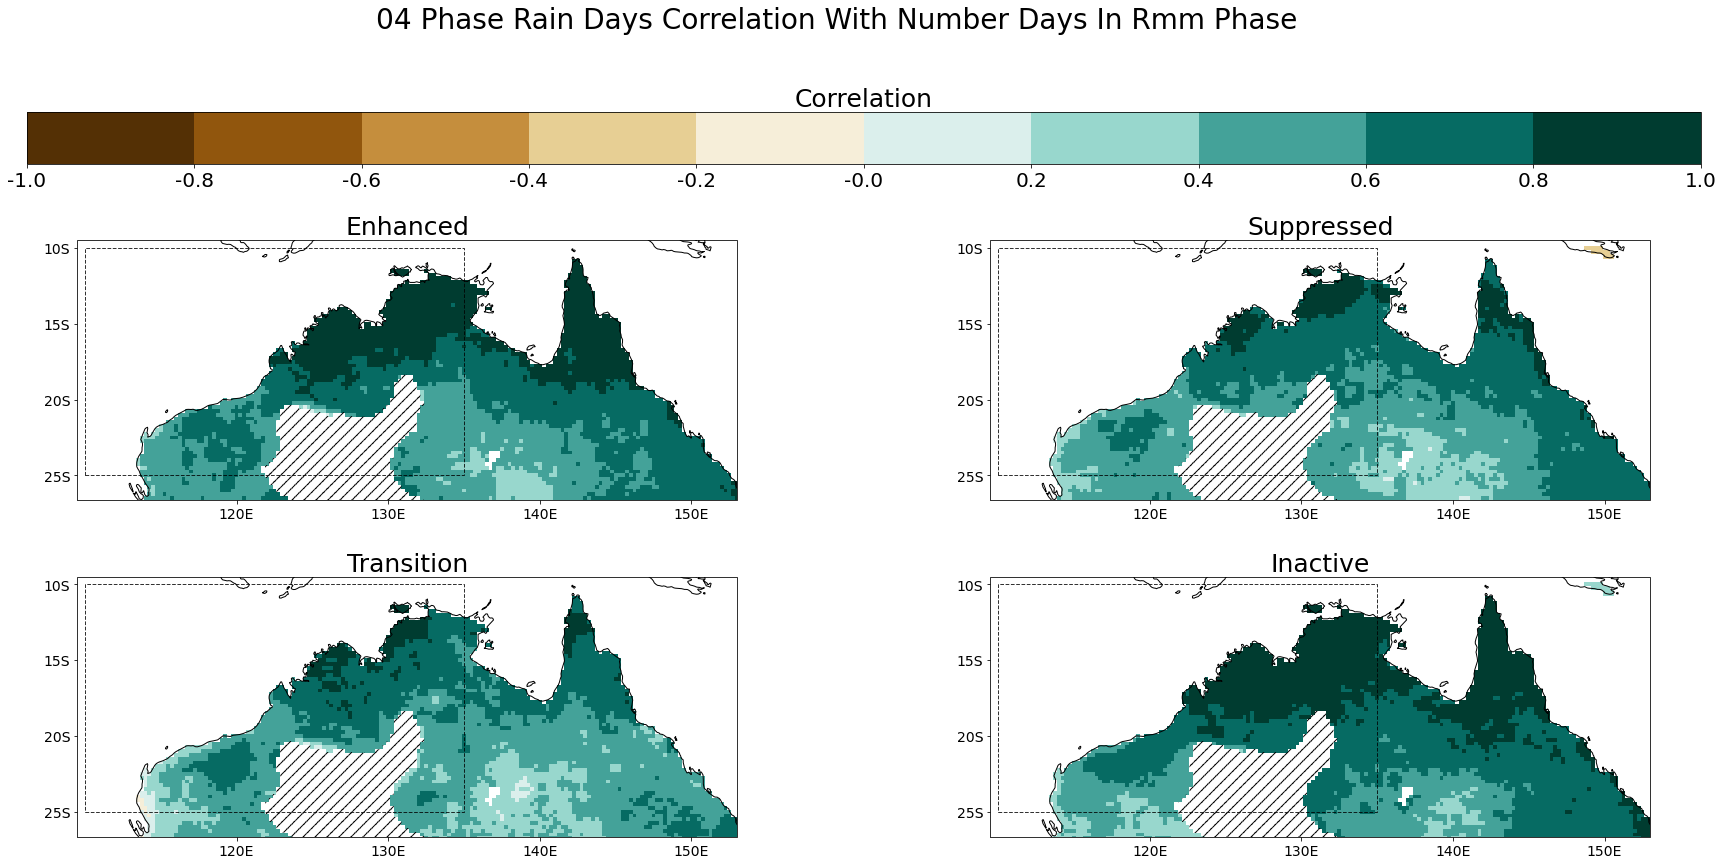

In [42]:
reload(map_trend_functions)
map_trend_functions.trend_plots(count_corr_da,
               vmax = 1, step = 0.2, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_phase_rain_days_correlation_with_number_days_in_rmm_phase', colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

## Space Aggregation

In [43]:
awap_sum_sub

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, phase: 4, year: 46)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [44]:
awap_sum_sub_space_agg = awap_sum_sub.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).sum(dim=['lat', 'lon'])
awap_count_sub_space_agg = awap_count_sub.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).sum(dim=['lat', 'lon'])
awap_sum_sub_space_agg

<xarray.Dataset>
Dimensions:  (phase: 4, year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year) float64 2.707e+05 4.349e+05 ... 1.147e+05 2.458e+05

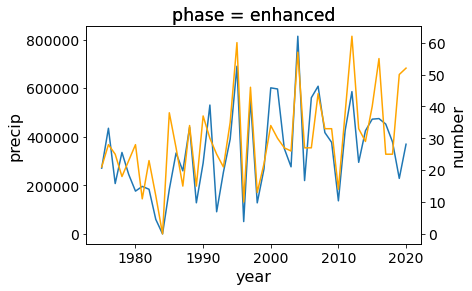

In [45]:
phase = 'enhanced'

fig = plt.figure()
ax = fig.add_subplot(111)
awap_sum_sub_space_agg.sel(phase=phase).precip.plot(ax=ax)
ax2 = ax.twinx()
rmm_count_sub.sel(phase=phase).number.plot(ax=ax2, color='orange')

In [46]:
sum_agg_corr = xr.corr(awap_sum_sub_space_agg.precip, rmm_count_sub.number, dim='year')
sum_agg_corr

<xarray.DataArray (phase: 4)>
array([0.72823185, 0.6048185 , 0.60832939, 0.8074147 ])
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [47]:
count_agg_corr = xr.corr(awap_count_sub_space_agg.precip, rmm_count_sub.number, dim='year')
count_agg_corr

<xarray.DataArray (phase: 4)>
array([0.88085457, 0.80131144, 0.8111312 , 0.88196573])
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [48]:
# fig = plt.figure(figsize = (10,28/9*4))#(18,20))
# gs = gridspec.GridSpec(4,1, hspace = 0.4)


# sig_stor = []

# for i,phase in enumerate(subphase_count_ot.phase.values):
#     ax = fig.add_subplot(gs[i])
    
#     single_phase_ot = subphase_count_ot.sel(phase = phase).number
#     mjo_single_phase_line_plot(ax, single_phase_ot, linecolor=green, label='OT')
    
    
#     single_phase_wh = subphase_count_wh.sel(phase = phase).number
#     mjo_single_phase_line_plot(ax, single_phase_wh, linecolor=brown, label='WH')
    
    
#     # Defining titles
#     if phase == 'inactive':
#         ax.set_title('Inactive Phase', size=16)
#         ax.set_ylim([0, 90])
#     else:
#         ax.set_title(phase.capitalize(), size=16)
#         ax.set_ylim(0,60)
#     ax.set_ylabel('Number of Days')
#     ax.set_xlabel('Year')
#     leg = ax.legend(loc = 'upper left', ncol=2)
#     leg.set_title(f'Correlation - {pcor:.2f}')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.annotate(chr(97+i) +')', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


# title = 'Number of Days in each MJO Phase per Year'
# fig.suptitle(title, y =0.94, fontsize = 15 );


# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, 'rmm_trend_subphase_DecToMarch_OT_and_WH_col1_4rows.png'), 
#                          dpi = 800, bbox_inches = 'tight')